In [ ]:
!gdown --id 1-7BN2LygK1GNhGVvtEwA4WGrjQXoGg5A

Downloading...
From: https://drive.google.com/uc?id=1-7BN2LygK1GNhGVvtEwA4WGrjQXoGg5A
To: /content/blur.npz
314MB [00:02, 142MB/s]


In [ ]:
from numpy import load
import matplotlib.pyplot as plt

In [ ]:
data = load("blur.npz")
print(data.files)

['arr_0', 'arr_1']


In [ ]:
src_images, tar_images = data['arr_0'], data['arr_1']
print("Source(Blur) Shape :", src_images.shape, "\nTarget(Sharp) Shape:", tar_images.shape)

Source(Blur) Shape : (1029, 256, 256, 3) 
Target(Sharp) Shape: (1029, 256, 256, 3)


In [ ]:
from random import randint

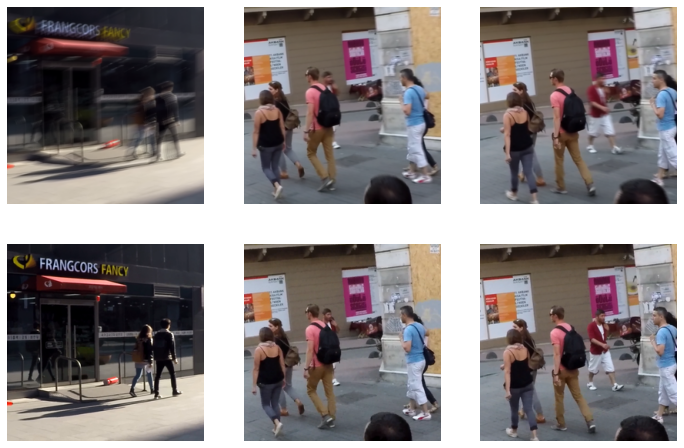

In [ ]:
n = randint(0, 100)
plt.figure(figsize=(12,8))
for i in range(3):
  plt.subplot(2, 3, i+1)
  plt.axis("off")
  plt.imshow(src_images[i+n])
for i in range(3):
  plt.subplot(2, 3, i+1+3)
  plt.axis("off")
  plt.imshow(tar_images[i+n])
plt.show()

In [ ]:
src_images = src_images.astype('float32')
tar_images = tar_images.astype('float32')

In [ ]:
src_images = (src_images - 127.5)/127.5
tar_images = (tar_images -127.5)/127.5

In [ ]:
from numpy import ones, zeros
from numpy.random import randint, randn

In [ ]:
def generate_real_samples(n, patch_shape):
  ix = randint(0, src_images.shape[0], n)
  X1 = src_images[ix]
  X2 = tar_images[ix]
  y = ones((n, patch_shape, patch_shape, 1))
  return [X1, X2], y

In [ ]:
def generate_fake_smaples(generator, samples, patch_shape):
  X = generator.predict(samples)
  y = zeros((len(X), patch_shape, patch_shape, 1))
  return X, y

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
base_path = "gdrive/MyDrive/8th-Sem-Project/deblur"

In [ ]:
!mkdir "gdrive/MyDrive/8th-Sem-Project"
!mkdir "gdrive/MyDrive/8th-Sem-Project/deblur"
!mkdir "gdrive/MyDrive/8th-Sem-Project/deblur/Plots"
!mkdir "gdrive/MyDrive/8th-Sem-Project/deblur/Generators"
!mkdir "gdrive/MyDrive/8th-Sem-Project/deblur/Discriminators"

!ls "gdrive/MyDrive/8th-Sem-Project/deblur"

mkdir: cannot create directory ‘gdrive/MyDrive/8th-Sem-Project’: File exists
mkdir: cannot create directory ‘gdrive/MyDrive/8th-Sem-Project/deblur’: File exists
mkdir: cannot create directory ‘gdrive/MyDrive/8th-Sem-Project/deblur/Plots’: File exists
mkdir: cannot create directory ‘gdrive/MyDrive/8th-Sem-Project/deblur/Generators’: File exists
mkdir: cannot create directory ‘gdrive/MyDrive/8th-Sem-Project/deblur/Discriminators’: File exists
Discriminators	Generators  Plots


In [ ]:
def summarize_performance(step, generator, discriminator, n=3):
  [X_realA, X_realB], _ = generate_real_samples(n, 1)
  X_fakeB, _ = generate_fake_smaples(generator, X_realA, 1)
  X_realA = (X_realA+1)/2
  X_realB = (X_realB+1)/2
  X_fakeB = (X_fakeB+1)/2

  fig = plt.figure(figsize=(24, 16))
  for i in range(n):
    plt.subplot(3, n, 1+i)
    plt.axis("off")
    plt.imshow(X_realA[i])
    
  for i in range(n):
    plt.subplot(3, n, 1+n+i)
    plt.axis("off")
    plt.imshow(X_fakeB[i])
    
  for i in range(n):
    plt.subplot(3, n, 1+2*n+i)
    plt.axis("off")
    plt.imshow(X_realB[i])

  plt.savefig(base_path+"/Plots/plot_%04d.png"%(step+1))
  plt.close(fig)
  generator.save(base_path+"/Generators/gen_%04d.tf"%(step+1), save_format='tf')
  discriminator.save(base_path+"/Discriminators/dis_%04d.tf"%(step+1), save_format='tf')
  print("Saved Models and plot for step:", step+1)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization, Dropout, Add
from tensorflow.keras.layers import LeakyReLU, Conv2DTranspose, Lambda, Flatten, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
def res_block(input, filters, kernel_size=(3,3), strides=(1,1), use_dropout=False):
  x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same", strides=strides,)(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  if use_dropout:
      x = Dropout(0.5)(x)

  x = Conv2D(filters=filters, kernel_size=kernel_size, padding="same", strides=strides,)(x)
  x = BatchNormalization()(x)

  merged = Add()([input, x])
  return merged

In [ ]:
ngf = 64
input_nc = 3
output_nc = 3
input_shape_generator = (256, 256, input_nc)
n_blocks_gen = 9


def generator_model():
    """Build generator architecture."""
    # Current version : ResNet block
    inputs = Input(shape=image_shape)

    # x = ReflectionPadding2D((3, 3))(inputs)
    x = Conv2D(filters=ngf, kernel_size=(7,7), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Increase filter number
    n_downsampling = 2
    for i in range(n_downsampling):
        mult = 2**i
        x = Conv2D(filters=ngf*mult*2, kernel_size=(3,3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # Apply 9 ResNet blocks
    mult = 2**n_downsampling
    for i in range(n_blocks_gen):
        x = res_block(x, ngf*mult, use_dropout=True)

    # Decrease filter number to 3 (RGB)
    for i in range(n_downsampling):
        mult = 2**(n_downsampling - i)
        x = Conv2DTranspose(filters=int(ngf * mult / 2), kernel_size=(3,3), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

    # x = ReflectionPadding2D((3,3))(x)
    x = Conv2D(filters=output_nc, kernel_size=(7,7), padding='same')(x)
    x = Activation('tanh')(x)

    # Add direct connection from input to output and recenter to [-1, 1]
    outputs = Add()([x, inputs])
    outputs = Lambda(lambda z: z/2)(outputs)

    model = Model(inputs=inputs, outputs=outputs, name='Generator')
    return model

In [ ]:
ndf = 64
output_nc = 3
input_shape_discriminator = (256, 256, output_nc)


def discriminator_model():
    """Build discriminator architecture."""
    n_layers, use_sigmoid = 3, False
    inputs = Input(shape=input_shape_discriminator)

    x = Conv2D(filters=ndf, kernel_size=(4,4), strides=2, padding='same')(inputs)
    x = LeakyReLU(0.2)(x)

    nf_mult, nf_mult_prev = 1, 1
    for n in range(n_layers):
        nf_mult_prev, nf_mult = nf_mult, min(2**n, 8)
        x = Conv2D(filters=ndf*nf_mult, kernel_size=(4,4), strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

    nf_mult_prev, nf_mult = nf_mult, min(2**n_layers, 8)
    x = Conv2D(filters=ndf*nf_mult, kernel_size=(4,4), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(filters=1, kernel_size=(4,4), strides=1, padding='same')(x)
    if use_sigmoid:
        x = Activation('sigmoid')(x)

    x = Flatten()(x)
    x = Dense(1024, activation='tanh')(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=x, name='Discriminator')
    return model

In [ ]:
def generator_containing_discriminator_multiple_outputs(generator, discriminator):
    inputs = Input(shape=image_shape)
    generated_images = generator(inputs)
    outputs = discriminator(generated_images)
    model = Model(inputs=inputs, outputs=[generated_images, outputs])
    return model

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16

image_shape = (256, 256, 3)
vgg = VGG16(include_top=False, weights='imagenet', input_shape=image_shape)
loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
loss_model.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
def perceptual_loss(y_true, y_pred):
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))

In [ ]:
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true*y_pred)

In [ ]:
from numpy import ones, mean, add
from numpy.random import permutation

In [ ]:
def train(batch_size, epoch_num, critic_updates=5):
  x_train = src_images
  y_train = tar_images

  g = generator_model()
  d = discriminator_model()

  d_on_g = generator_containing_discriminator_multiple_outputs(g, d)
  d_on_g.summary()

  d_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  d_on_g_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

  d.trainable = True
  d.compile(optimizer=d_opt, loss=wasserstein_loss)
  d.trainable = False
  loss = [perceptual_loss, wasserstein_loss]
  loss_weights = [100, 1]

  d_on_g.compile(optimizer=d_on_g_opt, loss=loss, loss_weights=loss_weights)
  d.trainable = True

  output_true_batch, output_false_batch = ones((batch_size, 1)), -ones((batch_size, 1))
  summarize_performance(-1, g, d)
  for epoch in range(epoch_num):
    permutated_indexes = permutation(x_train.shape[0])

    d_losses = []
    d_on_g_losses = []
    for index in range(int(x_train.shape[0] / batch_size)):
      batch_indexes = permutated_indexes[index*batch_size:(index+1)*batch_size]
      image_blur_batch = x_train[batch_indexes]
      image_full_batch = y_train[batch_indexes]

      generated_images = g.predict(x=image_blur_batch, batch_size=batch_size)

      for _ in range(critic_updates):
        d_loss_real = d.train_on_batch(image_full_batch, output_true_batch)
        d_loss_fake = d.train_on_batch(generated_images, output_false_batch)
        d_loss = 0.5 * add(d_loss_fake, d_loss_real)
        d_losses.append(d_loss)

      d.trainable = False

      d_on_g_loss = d_on_g.train_on_batch(image_blur_batch, [image_full_batch, output_true_batch])
      d_on_g_losses.append(d_on_g_loss)

      d.trainable = True

    print('Epoch: {}   |   D_loss: {}   |   GAN_loss: {}'.format(epoch+1, mean(d_losses), mean(d_on_g_losses)))
    if (epoch+1)%10 == 0:
      summarize_performance(epoch, g, d)

In [ ]:
# train(10, 100)

# Load and Train

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
def load_and_train(batch_size, start_epoch_num, epoch_num, critic_updates=5):
  x_train = src_images
  y_train = tar_images

  g = load_model(base_path+"/Generators/gen_%04d.tf"%(start_epoch_num))
  d = load_model(base_path+"/Discriminators/dis_%04d.tf"%(start_epoch_num), custom_objects={'wasserstein_loss': wasserstein_loss})

  d_on_g = generator_containing_discriminator_multiple_outputs(g, d)
  d_on_g.summary()

  d_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
  d_on_g_opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

  d.trainable = True
  d.compile(optimizer=d_opt, loss=wasserstein_loss)
  d.trainable = False
  loss = [perceptual_loss, wasserstein_loss]
  loss_weights = [100, 1]

  d_on_g.compile(optimizer=d_on_g_opt, loss=loss, loss_weights=loss_weights)
  d.trainable = True

  output_true_batch, output_false_batch = ones((batch_size, 1)), -ones((batch_size, 1))
  summarize_performance(start_epoch_num-1, g, d)
  for epoch in range(start_epoch_num, epoch_num):
    permutated_indexes = permutation(x_train.shape[0])

    d_losses = []
    d_on_g_losses = []
    for index in range(int(x_train.shape[0] / batch_size)):
      batch_indexes = permutated_indexes[index*batch_size:(index+1)*batch_size]
      image_blur_batch = x_train[batch_indexes]
      image_full_batch = y_train[batch_indexes]

      generated_images = g.predict(x=image_blur_batch, batch_size=batch_size)

      for _ in range(critic_updates):
        d_loss_real = d.train_on_batch(image_full_batch, output_true_batch)
        d_loss_fake = d.train_on_batch(generated_images, output_false_batch)
        d_loss = 0.5 * add(d_loss_fake, d_loss_real)
        d_losses.append(d_loss)

      d.trainable = False

      d_on_g_loss = d_on_g.train_on_batch(image_blur_batch, [image_full_batch, output_true_batch])
      d_on_g_losses.append(d_on_g_loss)

      d.trainable = True

    print('Epoch: {}   |   D_loss: {}   |   GAN_loss: {}'.format(epoch+1, mean(d_losses), mean(d_on_g_losses)))
    if (epoch+1)%10 == 0:
      summarize_performance(epoch, g, d)

In [ ]:
load_and_train(10, 200, 300)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
Generator (Functional)       (None, 256, 256, 3)       11399171  
_________________________________________________________________
Discriminator (Functional)   (None, 1)                 3098370   
Total params: 14,497,541
Trainable params: 14,485,125
Non-trainable params: 12,416
_________________________________________________________________
INFO:tensorflow:Assets written to: gdrive/MyDrive/8th-Sem-Project/deblur/Generators/gen_0200.tf/assets
INFO:tensorflow:Assets written to: gdrive/MyDrive/8th-Sem-Project/deblur/Discriminators/dis_0200.tf/assets
Saved Models and plot for step: 200
Epoch: 201   |   D_loss: -0.49999999999992367   |   GAN_loss: 212.3575089963433
Epoch: 202   |   D_loss: -0.49999999999991385 